In [1]:
!pip install d2l
!pip install matplotlib==3.0.2

     |████████████████████████████████| 82 kB 786 kB/s 
     |████████████████████████████████| 61 kB 9.2 MB/s 
     |████████████████████████████████| 9.9 MB 49.3 MB/s 
     |████████████████████████████████| 10.3 MB 55.4 MB/s 
     |████████████████████████████████| 82 kB 764 kB/s 
     |████████████████████████████████| 20.1 MB 1.2 MB/s 
     |████████████████████████████████| 9.9 MB 70.1 MB/s 
     |████████████████████████████████| 11.6 MB 63.2 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
  Attempting uninstall: matplotlib
    Found existing installation: matplo

     |████████████████████████████████| 12.9 MB 8.8 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.3
    Uninstalling matplotlib-3.3.3:
      Successfully uninstalled matplotlib-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.2 which is incompatible.
mizani 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.2 which is incompatible.
d2l 0.17.3 requires matplotlib==3.3.3, but you have matplotlib 3.0.2 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


VGG Blocks

In [2]:
import torch
from torch import nn
from d2l import torch as d2l


def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

VGG Network

In [3]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

In [4]:
def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    # The convolutional part
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # The fully-connected part
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10))

net = vgg(conv_arch)

In [5]:
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


Training

In [6]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

loss 0.183, train acc 0.932, test acc 0.916
701.2 examples/sec on cuda:0


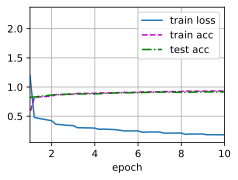

In [7]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

Summary

* VGG-11 constructs a network using reusable convolutional blocks. Different VGG models can be defined by the differences in the number of convolutional layers and output channels in each block.
* The use of blocks leads to very compact representations of the network definition. It allows for efficient design of complex networks.
* In their VGG paper, Simonyan and Ziserman experimented with various architectures. In particular, they found that several layers of deep and narrow convolutions (i.e., ) were more effective than fewer layers of wider convolutions.